## 0.必要なライブラリを準備する

In [1]:
#　必要なライブラリをインポートする
import numpy as np
import pandas as pd
from pprint import pprint as p
import warnings
warnings.simplefilter('ignore')
import openpyxl as px
import glob
import torch
import itertools
import transformers
transformers.BertTokenizer = transformers.BertJapaneseTokenizer
import sentence_transformers
from sentence_transformers import SentenceTransformer, losses, InputExample
from sentence_transformers import models
from sentence_transformers.datasets import SentencesDataset
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import tqdm
import matplotlib.pyplot as plt

## 1.モデルを準備する

In [3]:
# 事前学習済みBERTを読み込む
bert = models.Transformer("cl-tohoku/bert-base-japanese-whole-word-masking")
pooling = models.Pooling(
        bert.get_word_embedding_dimension(),
        pooling_mode_mean_tokens=True,
)
model = SentenceTransformer(modules=[bert, pooling])

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# パラメータを設定
BATCH_SIZE = 8
NUM_EPOCH = 20
EVAL_STEPS = 10
TRAIN_DATA = 100 # 全データ数は×6
EVAL_DATA = 10 # ×6

## 2.学習用のデータを準備する

In [5]:
doku = glob.glob('demo_data/dokujo-tsushin/*.txt')
it = glob.glob('demo_data/it-life-hack/*.txt')
lh = glob.glob('demo_data/livedoor-homme/*.txt')
print(len(doku), len(it), len(lh))

50 50 50


In [3]:
def make_rand_pair_indices(num):
    '''
    0~49の50個の数字からランダムなペアを指定した数作成する。
    '''
    indices = []
    while len(indices) < num:
        ran = np.random.randint(0, 49, 2)
        a = ran.min()
        b = ran.max()
        if (a, b) not in indices:
            indices.append((a,b))
        
    return indices

def show_encode_result(model, title):
    '''
    全データについて、エンコードしたベクトルから主成分分析し、二次元座標に可視化
    ラベルごとに色分けして結果を確認
    '''
    label = [0]*50 + [1]*50 + [2]*50
    vectors = []
    for cat in [doku, it, lh]:
        for path in tqdm.tqdm(cat):
            with open(path, 'r') as f:
                #最初の2行はゴミ
                f.readline()
                f.readline()
                txt = f.read()[:100]
            vectors.append(model.encode(txt))

    vectors = np.array(vectors)
    pca = PCA(n_components=2)
    pca_comp = pca.fit_transform(vectors)
    x = pca_comp[:,0]
    y = pca_comp[:,1]
    plt.figure(figsize=(5,5))
    plt.scatter(x, y, c=label)
    plt.title(title)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.savefig(f'{title}.png')
    plt.show()
    df = pd.DataFrame(vectors)
    df['label'] = label
    return df

In [7]:
#学習データの作成
#三つのカテゴリーの記事、各カテゴリーの組み合わせ（同じものも含む）についてTRAIN_DATA個ずつランダムに文書を選んでペアにする
train_samples = []
for a, b in itertools.combinations_with_replacement([doku, it, lh], 2):
    indices = make_rand_pair_indices(TRAIN_DATA)
    print(a==b)
    for t1, t2 in indices:
        with open(a[t1]) as f:
            #最初の2行はゴミ
            f.readline()
            f.readline()
            txt1 = f.read()[:100]
        
        with open(b[t2]) as f:
            #最初の2行はゴミ
            f.readline()
            f.readline()
            txt2 = f.read()[:100]

        sample = InputExample(texts=[txt1, txt2], label=int(a==b))
        train_samples.append(sample)
len(train_samples)


True
False
False
True
False
True


600

In [8]:
#検証データ作成
sent1 = []
sent2 = []
lab = []
for a, b in itertools.combinations_with_replacement([doku, it, lh], 2):
    indices = make_rand_pair_indices(EVAL_DATA)
    print(a==b)
    for t1, t2 in indices:
        with open(a[t1]) as f:
            f.readline()
            f.readline()
            sent1.append(f.read()[:100])
        
        with open(b[t2]) as f:
            f.readline()
            f.readline()
            sent2.append(f.read()[:100])

        lab.append(int(a==b))

evaluator = sentence_transformers.evaluation.BinaryClassificationEvaluator(sent1, sent2, lab, batch_size=BATCH_SIZE)

True
False
False
True
False
True


In [9]:
train_dataset = SentencesDataset(train_samples, model=model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
train_loss = losses.ContrastiveLoss(model=model)

100%|██████████| 50/50 [00:01<00:00, 43.90it/s]


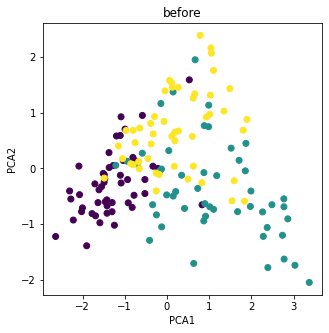

In [10]:
#学習前の結果を見ておく。
show_encode_result(model, 'before')

## 3.ファインチューニング

In [11]:
# ファインチューニングした結果は自動で保存される
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=NUM_EPOCH,
    evaluation_steps=EVAL_STEPS,
    output_path="./sbert",
    show_progress_bar=True)

Epoch: 100%|██████████| 20/20 [14:00<00:00, 42.04s/it]


100%|██████████| 50/50 [00:01<00:00, 44.58it/s]


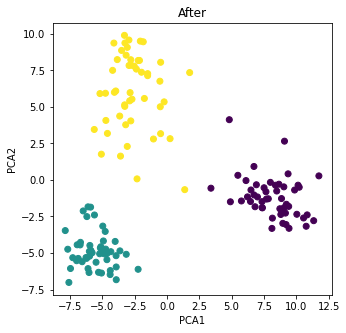

In [16]:
# 結果を表示
sbert = SentenceTransformer('./sbert')
df = show_encode_result(sbert, 'After')

In [17]:
df.to_csv('vectors.csv', index=False)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,-0.147905,-0.225576,0.341122,0.069662,-0.165634,-0.211405,-0.085786,0.050720,0.092274,0.001370,...,-0.222061,-0.324847,-0.010668,-0.865249,-1.117309,-0.405329,0.171807,1.037778,-0.010228,0
1,-0.202737,-0.615712,0.592441,0.337879,-0.179498,-0.214464,0.007708,0.009133,0.163826,0.165351,...,-0.036367,-0.164661,-0.170345,-0.645810,-1.203288,-0.441684,0.154063,0.800678,-0.009586,0
2,-0.107933,-0.368842,0.517745,-0.155417,-0.289008,-0.506042,-0.251902,0.181513,0.081488,-0.059575,...,-0.017356,-0.721811,-0.097873,-0.667257,-1.295446,-0.457542,0.252030,1.228164,0.255379,0
3,-0.178271,-0.133885,0.263827,-0.006133,-0.196564,-0.052863,-0.243951,0.196107,0.151322,-0.242504,...,-0.424846,-0.219309,-0.490638,-0.534292,-1.020068,-0.481659,0.171879,0.905037,0.293049,0
4,0.097398,-0.290838,0.342699,-0.105358,0.280920,0.281805,-0.361095,-0.071906,-0.003774,0.254018,...,-0.434982,0.182681,-0.246087,-0.784501,-1.126660,-0.374437,0.476488,0.643652,-0.211143,0


In [18]:
df = pd.read_csv('vectors.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,-0.147905,-0.225576,0.341122,0.069662,-0.165634,-0.211405,-0.085786,0.050720,0.092274,0.001370,...,-0.222061,-0.324847,-0.010668,-0.865249,-1.117309,-0.405329,0.171807,1.037778,-0.010228,0
1,-0.202737,-0.615712,0.592441,0.337879,-0.179498,-0.214464,0.007708,0.009133,0.163826,0.165351,...,-0.036367,-0.164661,-0.170345,-0.645810,-1.203288,-0.441684,0.154063,0.800678,-0.009586,0
2,-0.107933,-0.368842,0.517745,-0.155417,-0.289008,-0.506042,-0.251902,0.181513,0.081488,-0.059575,...,-0.017356,-0.721811,-0.097873,-0.667257,-1.295446,-0.457542,0.252030,1.228164,0.255379,0
3,-0.178271,-0.133885,0.263827,-0.006133,-0.196564,-0.052863,-0.243951,0.196107,0.151322,-0.242504,...,-0.424846,-0.219309,-0.490638,-0.534292,-1.020068,-0.481659,0.171879,0.905037,0.293048,0
4,0.097398,-0.290838,0.342699,-0.105358,0.280920,0.281805,-0.361095,-0.071906,-0.003774,0.254018,...,-0.434982,0.182681,-0.246087,-0.784501,-1.126660,-0.374437,0.476488,0.643652,-0.211143,0


In [19]:
sbert = SentenceTransformer('./sbert')
vec1 = sbert.encode('過去の恋愛の想い出をきれい残したいのなら、知らないほうがいいこともあるかもしれません')
vec2 = sbert.encode('・Excelの新規ファイルにムダなシートを作らない')
vec3 = sbert.encode('メタボリックシンドローム最大の原因は食事・運動・休養の“生活習慣”にあります。')

In [22]:
x = df.drop(['label'], axis=1).values
y = df['label'].values

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x, y)


KNeighborsClassifier(n_neighbors=3)

In [30]:
for vec in [vec1, vec2, vec3]:
    print(knn.kneighbors(vec1.reshape(1, -1), 3))

(array([[6.53828408, 6.69076905, 6.74868151]]), array([[25, 45, 42]], dtype=int64))
(array([[6.53828408, 6.69076905, 6.74868151]]), array([[25, 45, 42]], dtype=int64))
(array([[6.53828408, 6.69076905, 6.74868151]]), array([[25, 45, 42]], dtype=int64))
